In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning.
import pandas as pd  # for data processing and CSV file I/O
import numpy as np  # for numerical operations
import plotly.express as px  # for interactive plotting
from sklearn.preprocessing import MinMaxScaler  # for feature scaling
import os  # for interacting with the operating system
import gc  # for garbage collection to manage memory
import time  # for time-related functions
import warnings  # for handling warnings
from warnings import simplefilter  # to filter warnings
from itertools import combinations  # for creating combinations

# Import additional libraries for machine learning and data visualization.
import joblib  # for saving and loading models
import seaborn as sns  # for statistical data visualization
import matplotlib.pyplot as plt  # for plotting
from catboost import CatBoostRegressor, Pool  # for CatBoost model and data pool
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType  # for feature selection in CatBoost
from sklearn.linear_model import LinearRegression  # for linear regression modeling
from sklearn.metrics import mean_absolute_error  # for evaluating model performance

# Configure warnings to ignore specific categories.
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Import functions for splitting data and evaluating models.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import libraries for hyperparameter tuning.
import optuna as opt  # for hyperparameter tuning



In [2]:
# Load the training dataset from a CSV file into a pandas DataFrame.
train = pd.read_csv("train.csv")

In [3]:
# Display the first 20 rows of the training dataset for inspection.
train.head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


In [4]:
# Determine the number of rows and columns in the training dataset.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  9999
Number of Columns:  17


In [5]:
# Remove rows with missing values in the 'target' column from the training dataset.
train = train.dropna(subset=["target"])

# 🔁 Reset the index of the DataFrame and apply the changes in place
train.reset_index(drop=True, inplace=True)

# Re-evaluate the shape of the DataFrame after removing missing values.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  9999
Number of Columns:  17


In [6]:
# Calculate Relative Strength Index (RSI) based on 'reference_price' changes.
pos_changes = train['reference_price'].diff().clip(lower=1)
neg_changes = train['reference_price'].diff().clip(upper=1)
# Calculate the Relative Strength Index (RSI) based on the 'reference_price' changes.
train['RSI'] = 1 - (100/(1 + pos_changes/neg_changes))

In [10]:
# Define the window size for the Simple Moving Average (SMA).
window_size = 2
# Compute the SMA, simple moving averages, for each stock and the 'wap' column
train['SMA'] = train.groupby('stock_id')['wap'].transform(lambda x: x.rolling(window=window_size,  min_periods=1).mean())

DataError: No numeric types to aggregate

In [4]:
# Calculate the daily weighted average price (WAP) sum and average it over the number of rows per day.
daily_wap_sum = train.groupby('date_id')['wap'].sum()
# Calculate the number of rows per day.
rows_per_day = train.groupby('date_id').size()
# Calculate the daily average WAP.
overall_average_wap = daily_wap_sum / rows_per_day
# Merge the daily average WAP with the training data.
train = train.merge(overall_average_wap.reset_index(name='daily_average_wap'), on='date_id', how='left')

In [7]:
#⚡Optiver 🚀Robust Best ⚡ Single Model features
# Calculate various features related to market dynamics.
train["volume"] = train.eval("ask_size + bid_size")
train["mid_price"] = train.eval("(ask_price + bid_price) / 2")
train["liquidity_imbalance"] = train.eval("(bid_size-ask_size)/(bid_size+ask_size)")
train["matched_imbalance"] = train.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
train["size_imbalance"] = train.eval("bid_size / ask_size")
train["price_spread"] = train["ask_price"] - train["bid_price"]
train['market_urgency'] = train['price_spread'] * train['liquidity_imbalance']

In [8]:
# Display the first 20 rows of the modified training dataset.
train.head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,time_id,row_id,RSI,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,0,0_0_0,NaN,69144.53,0.999919,0.754340,-0.615890,7.141326,0.000214,1.614287e-04
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,0,0_0_1,0.991601,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-5.567654e-04
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,0,0_0_2,1.033511,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,2.979771e-04
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,0,0_0_3,0.939037,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-2.129231e-04
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,0,0_0_4,1.063941,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,5.900832e-04
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,...,0,0_0_5,0.889822,7610.37,1.000207,-0.484199,-1.000000,0.347529,0.000856,-4.144739e-04
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,...,0,0_0_6,1.052027,10473.64,0.999895,0.272368,-0.579870,1.748641,0.000777,2.116296e-04
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,...,0,0_0_7,1.029709,7709.80,0.999935,0.333160,-0.386262,1.999222,0.000389,1.295994e-04
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,...,0,0_0_8,0.990201,54180.96,0.999532,0.919922,-0.596417,23.975550,0.001019,9.374002e-04
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,...,0,0_0_9,0.894811,12390.00,1.000000,-0.000646,-0.345503,0.998709,0.001292,-8.342211e-07


In [9]:
# Display the last 20 rows of the modified training dataset.
train.tail(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,time_id,row_id,RSI,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
9979,47,0,520,330278.21,1,1.001541,4915371.04,1.003499,1.002194,1.001324,...,52,0_520_47,1.265704,205508.04,1.001432,0.650475,-0.874075,4.722051,0.000217,0.000141
9980,48,0,520,0.00,0,1.000671,13784828.57,1.000671,1.000671,1.000628,...,52,0_520_48,1.087076,152439.68,1.000714,-0.159593,-1.000000,0.724744,0.000171,-0.000027
9981,49,0,520,1009678.13,1,1.000503,17056643.44,1.002166,1.001058,1.000226,...,52,0_520_49,1.016803,568956.96,1.000364,0.108028,-0.888225,1.242222,0.000277,0.000030
9982,50,0,520,3440818.48,-1,0.997804,14183978.31,0.997186,0.997495,0.997743,...,52,0_520_50,1.270630,194889.28,0.997866,0.390623,-0.609548,2.282043,0.000247,0.000096
9983,51,0,520,0.00,0,1.002089,18068902.25,1.002089,1.002089,1.002041,...,52,0_520_51,0.573328,60753.52,1.002160,-0.388989,-1.000000,0.439896,0.000238,-0.000093
9984,52,0,520,0.00,0,0.998360,10810192.01,0.998360,0.998360,0.997940,...,52,0_520_52,1.374296,83921.25,0.998150,0.710534,-1.000000,5.909282,0.000420,0.000298
9985,53,0,520,0.00,0,0.999556,39686528.89,0.999556,0.999556,0.999483,...,52,0_520_53,0.880543,308453.73,0.999556,-0.150360,-1.000000,0.738586,0.000146,-0.000022
9986,54,0,520,1175966.11,-1,1.001528,21931839.81,1.000448,1.001006,1.001493,...,52,0_520_54,0.803188,65574.54,1.001545,0.491189,-0.898219,2.930729,0.000105,0.000052
9987,55,0,520,2174877.50,-1,0.999451,14495114.34,0.997076,0.997807,0.999451,...,52,0_520_55,1.208132,420818.09,0.999542,-0.130762,-0.739067,0.768719,0.000182,-0.000024
9988,56,0,520,0.00,0,1.000230,14623016.13,1.000230,1.000230,1.000018,...,52,0_520_56,0.922161,358139.90,1.000124,0.834531,-1.000000,11.086822,0.000212,0.000177


Setting up training and testing data

In [10]:
# Drop certain columns from the dataset and remove missing values.
columns_to_drop = ['row_id', 'far_price', 'near_price']
train = train.drop(columns_to_drop, axis=1)
train = train.dropna()  

# Split the dataset into features (X) and target variable (y).
X = train.drop('target', axis=1)
y = train['target']

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset the index of the training data after splitting.
train.reset_index(drop=True, inplace=True)

# Re-evaluate the shape of the training data after splitting.
num_rows, num_columns = train.shape
print("Number of Rows: ", num_rows)
print("Number of Columns: ", num_columns)

Number of Rows:  9998
Number of Columns:  22


In [11]:
# Display the first few, default is 5, rows of the training dataset.
train.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,bid_price,bid_size,ask_price,...,target,time_id,RSI,volume,mid_price,liquidity_imbalance,matched_imbalance,size_imbalance,price_spread,market_urgency
0,1,0,0,166603.91,-1,0.999896,1642214.25,0.999896,3233.04,1.000660,...,-5.519986,0,0.991601,23838.13,1.000278,-0.728751,-0.815787,0.156905,0.000764,-0.000557
1,2,0,0,302879.87,-1,0.999561,1819368.03,0.999403,37956.00,1.000298,...,-8.389950,0,1.033511,56951.00,0.999850,0.332935,-0.714567,1.998210,0.000895,0.000298
2,3,0,0,11917682.27,-1,1.000171,18389745.62,0.999999,2324.90,1.000214,...,-4.010200,0,0.939037,481357.30,1.000107,-0.990340,-0.213547,0.004853,0.000215,-0.000213
3,4,0,0,447549.96,-1,0.999532,17860614.95,0.999394,16485.54,1.000016,...,-7.349849,0,1.063941,16919.64,0.999705,0.948687,-0.951109,37.976365,0.000622,0.000590
4,5,0,0,0.00,0,1.000635,13552875.92,0.999779,1962.72,1.000635,...,6.779432,0,0.889822,7610.37,1.000207,-0.484199,-1.000000,0.347529,0.000856,-0.000414


Linear Regression Error for comparison

In [13]:
# Initialize and train a Linear Regression model.
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions using Linear Regression
y_pred_linear = linear_model.predict(X_test)

# Evaluate the Linear Regression model using Mean Squared Error (MSE).
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error for Linear Regression: {mse_linear}')

Mean Squared Error for Linear Regression: 59.17994342888685


Catboost fitting

In [10]:
# Initialize and train a CatBoost Regressor model with specific parameters.
catboost_model = CatBoostRegressor(iterations=200, depth=10, learning_rate=0.05, loss_function='RMSE', random_seed=42)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

0:	learn: 7.9979677	test: 8.1266254	best: 8.1266254 (0)	total: 103ms	remaining: 20.6s
10:	learn: 7.6123871	test: 7.9027471	best: 7.9027471 (10)	total: 634ms	remaining: 10.9s
20:	learn: 7.3160711	test: 7.7615239	best: 7.7615239 (20)	total: 1.13s	remaining: 9.63s
30:	learn: 7.0787444	test: 7.6534408	best: 7.6534408 (30)	total: 1.59s	remaining: 8.68s
40:	learn: 6.9061328	test: 7.5775304	best: 7.5775304 (40)	total: 2.06s	remaining: 8.01s
50:	learn: 6.7364083	test: 7.4747059	best: 7.4747059 (50)	total: 2.55s	remaining: 7.45s
60:	learn: 6.5878774	test: 7.4129396	best: 7.4129396 (60)	total: 3.03s	remaining: 6.91s
70:	learn: 6.4238051	test: 7.3470572	best: 7.3470572 (70)	total: 3.48s	remaining: 6.33s
80:	learn: 6.2976826	test: 7.2838786	best: 7.2838786 (80)	total: 3.94s	remaining: 5.79s
90:	learn: 6.1563930	test: 7.2078242	best: 7.2078242 (90)	total: 4.41s	remaining: 5.29s
100:	learn: 6.0515345	test: 7.1628547	best: 7.1628547 (100)	total: 4.85s	remaining: 4.76s
110:	learn: 5.9286319	test: 7.10

Catboost error

In [14]:
# Make predictions using the trained CatBoost model.
y_pred = catboost_model.predict(X_test)
# Evaluate the CatBoost model using Mean Squared Error (MSE).
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

NameError: name 'catboost_model' is not defined

Column Importance

In [15]:
# Obtain feature importances from the CatBoost model.
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns
# Create a DataFrame for feature importances and sort it.
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

NameError: name 'catboost_model' is not defined

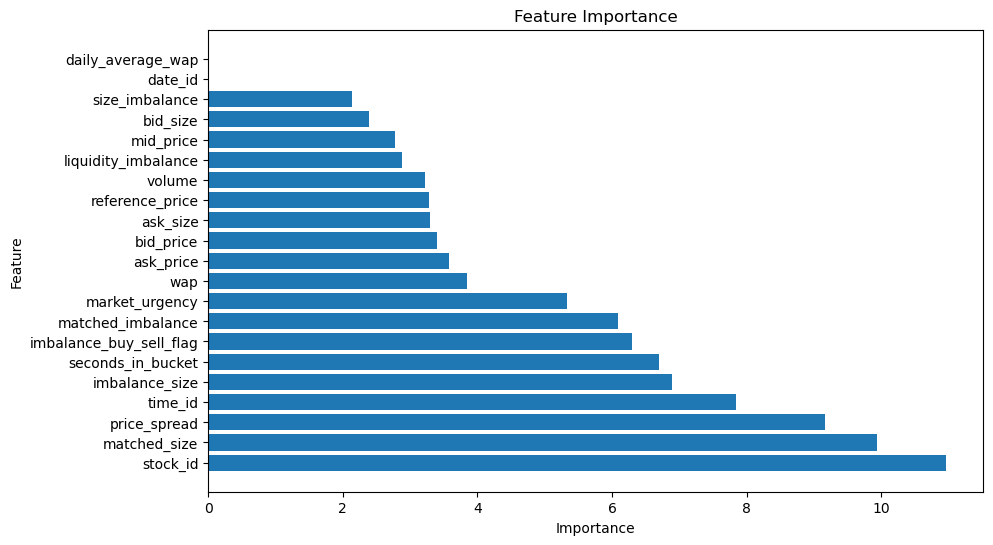

In [13]:
# Obtain feature importances from the CatBoost model.
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a DataFrame for feature importances and sort it.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Attempting to get SHAP to work

In [15]:
#columns_to_drop = ['target', 'far_price', 'near_price']
# Prepare the feature names for SHAP analysis, or simple h
#  ,excluding the target variable.
feature_name = train.columns.drop(['target']).tolist()

# Initialize the CatBoost model
ctb_model = CatBoostRegressor()

# Feature selection using SHAP values
# Create Pool object with both features (X) and target variable (y)
train_pool = Pool(X_train, label=y_train)

# Feature selection using SHAP values
summary = ctb_model.select_features(
    train_pool,  # Pass the Pool object that includes both features and target variable
    eval_set=[(X_test, y_test)],
    features_for_select=feature_name,
    num_features_to_select=len(feature_name) - 24,  # Dropping from 124 to 100
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: /src/catboost/catboost/libs/features_selection/select_features.cpp:52: Number of features to select should be positive

# Hyperparameter Tuning

-Hyperparameter Tuning using Grid Search


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Grid Search.
# Here, we are specifying the combinations of parameters we want to try.
param_grid = {
    'depth': [6, 8, 10],  # 3 options for 'depth'
    'learning_rate': [0.01, 0.05, 0.1],  # 3 options for 'learning_rate'
    'iterations': [100, 200, 300]  # 3 options for 'iterations'
}

# Initialize CatBoost Regressor
catboost_grid_model = CatBoostRegressor(loss_function='RMSE', random_seed=42)

# Initialize GridSearchCV.
# This will test every combination of parameters in the param_grid.
# Since there are 3 parameters, each with 3 options, this will result in 3*3*3 = 27 total combinations.
# The cv=3 argument means that for each combination, 3-fold cross-validation is used.
grid_search = GridSearchCV(catboost_grid_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=10)

# Perform Grid Search.
# This will fit the model 27 times (for each combination of parameters) and each time with 3-fold CV.
# So, the model is actually being fit 27 * 3 = 81 times in total.
grid_search.fit(X_train, y_train)

# Display the best parameters and best score (mean squared error in this case).
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=6, iterations=100, learning_rate=0.01................
0:	learn: 8.1016661	total: 77.3ms	remaining: 7.65s
1:	learn: 8.0974666	total: 171ms	remaining: 8.4s
2:	learn: 8.0913457	total: 238ms	remaining: 7.69s
3:	learn: 8.0854936	total: 291ms	remaining: 6.98s
4:	learn: 8.0801927	total: 331ms	remaining: 6.29s
5:	learn: 8.0749664	total: 393ms	remaining: 6.16s
6:	learn: 8.0691404	total: 462ms	remaining: 6.14s
7:	learn: 8.0648236	total: 620ms	remaining: 7.13s
8:	learn: 8.0604055	total: 717ms	remaining: 7.25s
9:	learn: 8.0567686	total: 810ms	remaining: 7.29s
10:	learn: 8.0522763	total: 846ms	remaining: 6.85s
11:	learn: 8.0470734	total: 878ms	remaining: 6.44s
12:	learn: 8.0428743	total: 918ms	remaining: 6.15s
13:	learn: 8.0382434	total: 945ms	remaining: 5.8s
14:	learn: 8.0326410	total: 978ms	remaining: 5.54s
15:	learn: 8.0287190	total: 1.02s	remaining: 5.35s
16:	learn: 8.0233948	total: 1.13s	remaining: 5.53s
17

 Hyperparameter Tuning using Randomized Search



In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for Randomized Search.
# Unlike Grid Search, we provide a range or distribution for each parameter.
param_dist = {
    'depth': [6, 8, 10],  # 3 options for 'depth'
    'learning_rate': uniform(0.01, 0.1),  # Continuous range for 'learning_rate'
    'iterations': [100, 200, 300]  # 3 options for 'iterations'
}

# Initialize RandomizedSearchCV.
# This will randomly sample parameter combinations from the distributions.
# The n_iter parameter defines how many different parameter combinations to try.
# Here, 10 iterations means 10 different combinations will be tried.
random_search = RandomizedSearchCV(catboost_grid_model, param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=10, random_state=42)

# Perform Randomized Search.
# The model will be fit 10 times (for each randomly sampled combination) and each time with 3-fold CV.
# So, the model is actually being fit 10 * 3 = 30 times in total.
random_search.fit(X_train, y_train)

# Display the best parameters and best score.
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START depth=10, iterations=100, learning_rate=0.028343478986616377
0:	learn: 8.0086135	total: 33.9ms	remaining: 3.36s
1:	learn: 7.9808040	total: 64ms	remaining: 3.13s
2:	learn: 7.9555873	total: 95.4ms	remaining: 3.08s
3:	learn: 7.9294385	total: 134ms	remaining: 3.21s
4:	learn: 7.9047600	total: 167ms	remaining: 3.17s
5:	learn: 7.8775149	total: 203ms	remaining: 3.17s
6:	learn: 7.8523634	total: 240ms	remaining: 3.19s
7:	learn: 7.8316390	total: 274ms	remaining: 3.15s
8:	learn: 7.8072983	total: 308ms	remaining: 3.11s
9:	learn: 7.7833155	total: 341ms	remaining: 3.06s
10:	learn: 7.7537270	total: 373ms	remaining: 3.02s
11:	learn: 7.7373126	total: 403ms	remaining: 2.96s
12:	learn: 7.7148791	total: 439ms	remaining: 2.94s
13:	learn: 7.6923050	total: 476ms	remaining: 2.92s
14:	learn: 7.6714664	total: 509ms	remaining: 2.89s
15:	learn: 7.6446218	total: 542ms	remaining: 2.85s
16:	learn: 7.6223304	total: 573ms	remaining: 2.8s


In [21]:
# %% [markdown]
# Hyperparameter Tuning using Optuna

# %%
import optuna

# Define the objective function that Optuna will optimize.
# Optuna will try to find the best values for 'iterations', 'depth', and 'learning_rate' to minimize the returned value (MSE in this case).
def objective(trial):
    # Define the hyperparameters to optimize.
    # Optuna will sample these during each trial.
    param = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }
    
    # Train the model with the current set of hyperparameters.
    model = CatBoostRegressor(**param, loss_function='RMSE', random_seed=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, early_stopping_rounds=10)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create an Optuna study which is a single optimization run.
study = optuna.create_study(direction='minimize')

# Optuna will perform 10 trials.
# In each trial, Optuna will call the 'objective' function with a different set of hyperparameters.
# These hyperparameters are chosen based on the previous trials to minimize the objective function.
study.optimize(objective, n_trials=10)

# Display the best parameters and best score found by Optuna.
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)


[I 2023-12-04 21:49:10,925] A new study created in memory with name: no-name-9e1aa1cf-e77f-4b37-860d-5bfcce4b9894
[I 2023-12-04 21:49:20,658] Trial 0 finished with value: 54.02811244609434 and parameters: {'iterations': 262, 'depth': 10, 'learning_rate': 0.0129489929986956}. Best is trial 0 with value: 54.02811244609434.
[I 2023-12-04 21:49:22,450] Trial 1 finished with value: 51.592958882517024 and parameters: {'iterations': 142, 'depth': 8, 'learning_rate': 0.050142175453697785}. Best is trial 1 with value: 51.592958882517024.
[I 2023-12-04 21:49:26,598] Trial 2 finished with value: 44.0536777131041 and parameters: {'iterations': 278, 'depth': 8, 'learning_rate': 0.058402903144427774}. Best is trial 2 with value: 44.0536777131041.
[I 2023-12-04 21:49:28,083] Trial 3 finished with value: 48.164371907293976 and parameters: {'iterations': 141, 'depth': 7, 'learning_rate': 0.09342211549625119}. Best is trial 2 with value: 44.0536777131041.
[I 2023-12-04 21:49:29,888] Trial 4 finished wit

Best Parameters: {'iterations': 179, 'depth': 9, 'learning_rate': 0.09865863102894126}
Best Score: 40.238128976775435


Evaluation Criteria: Since the challenge uses MAE, we will use this metric to evaluate the performance of your models.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluation function using MAE
def evaluate_model_mae(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    mae = mean_absolute_error(y_test, y_pred)
    return mae, end_time - start_time


Evaluate Best Models from Each Tuning Method:

In [ ]:
# Evaluate Grid Search Best Model
best_grid_model = grid_search.best_estimator_
mae_grid, time_grid = evaluate_model_mae(best_grid_model, X_test, y_test)

# Evaluate Randomized Search Best Model
best_random_model = random_search.best_estimator_
mae_random, time_random = evaluate_model_mae(best_random_model, X_test, y_test)

# Evaluate Optuna Best Model
optuna_params = study.best_params
optuna_model = CatBoostRegressor(**optuna_params, loss_function='RMSE')
optuna_model.fit(X_train, y_train, verbose=0)
mae_optuna, time_optuna = evaluate_model_mae(optuna_model, X_test, y_test)


Compare Across Methods:

In [ ]:
# Compare the best hyperparameters and MAE from each method
print("Best Grid Search Parameters:", grid_search.best_params_, "MAE:", mae_grid)
print("Best Randomized Search Parameters:", random_search.best_params_, "MAE:", mae_random)
print("Best Optuna Parameters:", study.best_params, "MAE:", mae_optuna)


Model Selection Criteria:

Given the focus on MAE, the model with the lowest MAE should be prioritized. However, you should also consider model complexity and training time, especially if the performance difference is marginal.

In [ ]:
# Select the model with the lowest MAE
if mae_grid <= mae_random and mae_grid <= mae_optuna:
    final_model = best_grid_model
elif mae_random <= mae_optuna:
    final_model = best_random_model
else:
    final_model = optuna_model

print("Selected Final Model:", final_model)


Post-Tuning Analysis:

After selecting the best model, you might want to analyze its performance in more detail, such as plotting residuals, analyzing errors, or studying feature importance.

1. Plotting Residuals

Residuals are the differences between the observed values and the values predicted by the model. Plotting these can help in understanding the error distribution.

In [ ]:
import matplotlib.pyplot as plt

# Predicting with the final model
y_pred_final = final_model.predict(X_test)

# Calculating residuals
residuals = y_test - y_pred_final

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


2. Analyzing Errors

You can analyze the distribution of errors (residuals) to check for patterns. A well-performing model should have errors distributed randomly around zero.

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

3. Studying Feature Importance

Feature importance gives insight into which features are most influential in predicting the target variable.

In [ ]:
# Assuming that the final model is a tree-based model like CatBoost, Random Forest, etc.
feature_importance = final_model.get_feature_importance()

# Plotting feature importance
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(feature_importance)[::-1]
plt.barh(np.array(X_train.columns)[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


Model Validation:

Finally, validate the chosen model on a separate validation set to ensure it generalizes well.


In [ ]:
# Validate the selected model on a separate set
mae_val, _ = evaluate_model_mae(final_model, X_val, y_val)
print(f"Validation MAE: {mae_val}")